# Application of the Item Response Theory at the capsule level

We consider a capsule that consists of $N$ questions on a given subject.
Our goal is to find out the student's ability on that subject, $\theta$, and the minimal list of questions that allows us to estimate $\theta$ with reasonable error.

## Global imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LogisticRegression
from scipy.stats import rv_continuous, norm, truncnorm, beta
from scipy.integrate import quad
from numba import jit

from igraph import Graph
from igraph.drawing import plot as igraph_plot

## The Item Response Theory

In the IRT model, the probability $P$ that a student with ability $\theta$ answers a question correctly is given by:
$$P(\theta) = c + \frac{1-c}{1 + \exp (-a \cdot (\theta - b))}$$
where $a$ is the \emph{discrimination} parameter of the question, $b$ is its \emph{difficulty} and $c$ is the probability of answering it correctly by chance (for instance, $1/n$ if it is a single-answer MCQ with $n$ propositions). We will also compare this framework with with the normal ogive model :
$$P(\theta) = c + (1-c)\Phi(a \cdot (\theta - b))$$
Where $\Phi$ is the Cumulative Distribution Function (CDF) of a standard normal distribution.

The underlying model is that a student who does not answer by chance will answer correctly if the latent variable
$$U^\ast = a \cdot (\theta - b) + \epsilon$$
is greater than 0, where $\epsilon$ is an unobserved error term that follows a logistic distribution.

The variable that denotes whether the answer was answer correctly, $U$, will be equal to one iff a uniform RV draw gives a value greater than $c$ or if $U^\ast > 0$.

We start be defining helper functions that describe the model.

In [3]:
def irt_latent_variable(a, b, theta, mode="3pl", eps_variance=None):
    """
    Generates a latent variable U* indicating the student's propensity of answering correctly
    based on the question's parameters (a and b) and the student's ability (theta).
    The unobserved error term has variance eps_variance.
    """
    if mode.lower() == "3pl":
        scale = 1.0 if eps_variance is None else sqrt(3 * eps_variance) / np.pi
        return a * (theta - b) + np.random.logistic(scale=scale)
    elif mode.lower() == "ogive":
        scale = 1.0 if eps_variance is None else eps_variance
        return a * (theta - b) + np.random.normal(scale=scale)
    else:
        raise ValueError("Unknown mode: %s" % mode)
        

def did_answer_correctly(u_star=None, chance=0.0):
    """
    Computes whether the student gave a correct answer (variable U)
    given the latent variable U star and the probability of answering correctly by chance, c.
    """
    
    if chance > 1.0 or chance < 0.0:
        raise ValueError("chance must be between 0.0 and 1.0.")
    chance_draw = np.random.uniform()
    if chance_draw < chance:
        return True
    else:
        return u_star > 0.0
    
def proba_irt(a, b, c, theta, mode="3pl"):
    """
    Returns the probability of answering correctly a question of parameters a, b and c given ability theta.
    :param a: Question discrimination
    :param b: Question difficulty
    :param c: Probability of answering correctly by chance
    :param theta: Student's ability
    :return: Probability of answering correctly the question (between 0 and 1)
    """
    
    if mode.lower() == "3pl":
        return c + (1. - c) / (1. + exp(-a * (theta - b)))
    elif mode.lower() == "ogive":
        return c + (1. - c) * norm.cdf(a * (theta-b))
    else:
        raise ValueError("Unkwown mode: %s" % mode)

def proba_irt_array(a, b, c, theta, mode="3pl"):
    """
    Compute the probabilities of answering a series of questions with parameters a, b, c.
    :param a: List of questions discrimination parameters
    :param b: List of questions difficulty parameters
    :param c: List of probabilities of answering each question correctly by chance
    :param theta: Student's ability (float)
    :return: Array of probability of answering each question correctly 
    """
    
    probas = []
    for i in range(len(a)):
        probas.append(proba_irt(a[i], b[i], c[i], theta, mode=mode))
    return np.array(probas)

To test the functions above, we simulate a series of answers to a given question by a given student and check that the frequency of correct answers is consistent with the probability predicted by the IRT model.

In [417]:
# Play around with the parameters below:
a = 2.0
b = 1.0
c = 0.2
theta = 0.8
N = 10000

# Compute the theoretical probability of answering correctly:
probability = proba_irt(a, b, c, theta)

# Answer the question N times
answers = []
for _ in range(N):
    u_star = irt_latent_variable(a, b, theta)
    u = did_answer_correctly(u_star, chance=c)
    answers.append(u)

frequency = np.mean(answers)

"Probability: %f /// Actual frequency: %f" % (probability, frequency)

'Probability: 0.521050 /// Actual frequency: 0.519500'

## Likelihood of the parameters

We create a function that computes the log-likelihood of $(a, b, c, \theta)$ where the first three parameters are vectors whose lengths match the number of questions, and $\theta$ is the ability of the student.
We are given the value of $U$ for each question.

In [418]:
def likelihood(a, b, c, theta, u, mode="3pl"):
    p = proba_irt_array(a, b, c, theta, mode=mode)
    ones = np.ones(len(u))
    return np.prod((p**u)*((ones-p)**(ones-u)))

def neg_log_likelihood(a, b, c, theta, u, mode="3pl"):
    p = proba_irt_array(a, b, c, theta, mode=mode)
    ones = np.ones(len(u))
    return -np.sum(u * log(p) + (ones - u) * log(ones-p))

In [419]:
# Question parameters (lengths match the number of questions)
a = [1.0, 2.0]
b = [0.0, 0.0]
c = [0.2, 0.2]

# Student ability
theta = 0.5

# Given answers
u = [True, False]

likelihood(a, b, c, theta, u)

0.15016988967740294

We assume $(a, b, c)$ as given and we want to find the value of $\theta$ that optimizes the likelihood for the given series of answers.
The function below does this, it accepts a starting value $\theta_0$ to initiate the Nelder-Mead algorithm. This will give us the Maximum Likelihood Estimator (MLE).

In [420]:
def opt_theta(a, b, c, u, mode="3pl"):
    return minimize_scalar(
        lambda theta: neg_log_likelihood(a, b, c, theta, u, mode="3pl"),
        tol=1e-8
    ).x

In [421]:
optimal_theta = opt_theta(a, b, c, u)
"Optimal theta: %f  /// Actual theta: %f" % (optimal_theta, theta)

'Optimal theta: -0.722705  /// Actual theta: 0.500000'

Another estimator that we can use is the Maximum A Posteriori Estimator. It is a bayesian estimator that maximizes the
a posteriori distribution of theta. We just have to compute for example a normal prior for theta. Then we can obtain the a posteriori distribution for theta by multiplying it by the Likelihood:

If you call the prior $g(\theta)$, the posterior will be:
$$g(\theta|u_{i_1},..,u_{i_k}) = \frac{L(\theta|u_{i_1},..,u_{i_k})g(\theta)}{\int L(\theta|u_{i_1},..,u_{i_k})g(\theta) \,\mathrm{d}\theta}$$

In [422]:
class posterior_dist_gen_3pl(rv_continuous):
    "Posterior distribution"
    def _pdf(self, theta1, a, b, c, u):
        return (likelihood(a, b, c, theta1, u, mode="3pl") * norm.pdf(theta1, loc=1.5)) / norm.expect(lambda theta: likelihood(a, b, c, theta, u, mode="3pl"), loc=1.)

class posterior_dist_gen_ogive(rv_continuous):
    "Posterior distribution"
    def _pdf(self, theta1, a, b, c, u):
        return (likelihood(a, b, c, theta1, u, mode="ogive") * norm.pdf(theta1, loc=1.5)) / norm.expect(lambda theta: likelihood(a, b, c, theta, u, mode="ogive"), loc=1.)    

We then implement the function to find the maximum a posteriori estimate

In [423]:
def maptheta(a, b, c, u, mode="3pl"):
    if mode == "3pl":
        posterior = posterior_dist_gen_3pl()
    elif mode == "ogive":
        posterior = posterior_dist_gen_ogive()
    return minimize_scalar(
        lambda theta: -likelihood(a, b, c, theta, u) * norm.pdf(theta, loc=0., scale=1.)
    ).x

def eaptheta(a, b, c, u, mode="3pl"):
    if mode == "3pl":
        posterior = posterior_dist_gen_3pl()
    elif mode == "ogive":
        posterior = posterior_dist_gen_ogive()
    return quad(func=lambda x: x * posterior._pdf(x, a, b, c, u), a=-np.inf, b=np.inf)

In [424]:
maptheta(a, b, c, u)

-0.32359916881649436

In [425]:
eaptheta(a, b, c, u)

(0.2860006477643417, 2.5879572568769383e-09)

## Finding the best question to estimate $\theta$

In this scenario, we consider the values of $(a, b, c)$ as given and the student has answered a subset of questions from the capsule. Our goal is to determine which question will best help us determine $\theta$.

The Fisher information of any subset of $k$ questions from the capsule is given by:
$$ I_{U_{i_1},..,U_{i_{k}}}(\theta) = \sum_{j=1}^{k}{\frac{p'_{i_j}(\theta)^2}{p_{i_j}(\theta)\cdot(1-p_{i_j}(\theta))}}$$

Information is additive, therefore in order to find the best question (that has not been asked yet), we just need to find the question $i$ that maximizes the quantity:
$$\frac{p'_i(\theta)^2}{p_i(\theta)\cdot(1-p_i(\theta))}$$

The next function computes this partial Fisher information for a given question of parameters $(a_i, b_i, c_i)$, given the current value of $\theta$.
We use the following equality:
$$ p'_{i_j}(\theta) = \frac{a_{i_j}\cdot(p_{i_j}(\theta)-c_{i_j})\cdot(1-p_{i_j}(\theta))}{1-c_{i_j}}$$

In [426]:
def partial_fisher_info(a, b, c, theta, mode="3pl"):
    p = proba_irt(a, b, c, theta, mode=mode)
    dp = a * (p - c) * (1. - p) / (1-c)
    return (dp ** 2) / (p * (1 - p))

def empirical_fisher_info(a, b, c, theta, mode="3pl"):
    p = proba_irt_array(a, b, c, theta, mode=mode)
    dp = a * (p - c) * (1 - p) / (1-c)
    return np.mean((dp ** 2) / (p * (1 - p)))

Then, we find the question that maximizes this partial information.

In [427]:
def find_best_question(question_parameters, theta, mode="3pl"):
    return np.argmax([partial_fisher_info(a, b, c, theta, mode=mode) for a, b, c in question_parameters])

Thanks to asymptotic theory of the Maximum Likelihood Estimator we know that :
$$\sqrt{n{I_1}}(\hat{\theta_n} - \theta_0) \rightarrow N(0,1)$$
Where $I_1$ stands for Fisher information for one observation, $\hat{\theta_n}$ is the MLE and n is the current number of observations. It is also easy to show that a strongly consistent estimator of $I_1(\theta_0)$ is :
$$\hat{I_1} = -\frac{1}{n}\sum_{i=1}^{n}{\frac{\partial^2}{\partial\theta^2}}\log{f(U_i;\hat{\theta_n})}$$
So thanks to Slutski theorem we know that :
$$\sqrt{n{\hat{I_1}}}(\hat{\theta_n} - \theta_0) \rightarrow N(0,1)$$
Which means that for the univariate case we can have a $100(1-\alpha)\%$ confidence interval:
$$\theta_0 \in \Bigg[\hat{\theta_n}-\frac{q_{1-\frac{\alpha}{2}}}{\sqrt{n\hat{I_1}}};\hat{\theta_n}+\frac{q_{1-\frac{\alpha}{2}}}{\sqrt{n\hat{I_1}}}\Bigg]$$
Where $q_{1-{\alpha/2}}$ is the quantile $1-\alpha/2$ of the standard normal distribution.


In [428]:
def confidence_interval(a, b, c, theta, alpha, mode="3pl"):
    I_1 = empirical_fisher_info(a, b, c, theta, mode=mode)
    N = len(a)
    ratio = norm.ppf(1 - alpha / 2) / sqrt(N * I_1)
    return theta - ratio, theta + ratio

## Finding one question's parameters $(a, b)$ given $(\theta, U)$ for a sample of users 

We are interested in a single question and we assume that we observe $\theta$ and $U$ for a sample of students.
The goal here is to find the value of $(a, b)$ for this question. We assume $c = 0$ in this section.

### Simulating answers from the students

In [433]:
# Real parameters of the question (no chance answer)
a = 2.0
b = 1.0

# Number of students
N = 10000

# Student abilities
theta = np.random.normal(size=N)

# Student answers
latent_variables = [irt_latent_variable(a, b, t) for t in theta]
u = [did_answer_correctly(u_star, 0.0) for u_star in latent_variables]

# Complete dataset
data = pd.DataFrame.from_dict({
        "theta": theta,
        "u": u,
        "intercept": np.ones(N)
    })

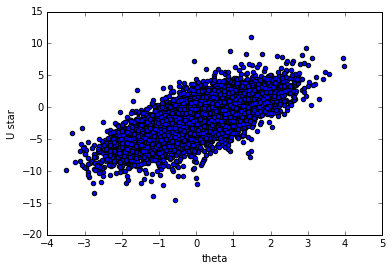

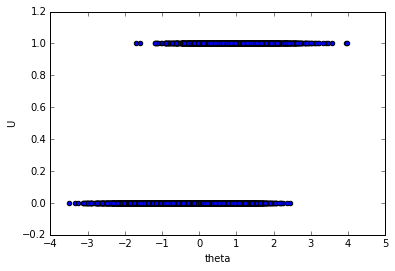

In [430]:
# Distribution of abilities and latent variables
plt.scatter(theta, latent_variables)
plt.xlabel("theta")
plt.ylabel("U star")
plt.show()

plt.scatter(theta, u)
plt.xlabel("theta")
plt.ylabel("U")
plt.show()

In [435]:
indep = data[data.columns - ["u"]]
dep = data["u"]

/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


In [440]:

logit = sm.Logit(dep, indep)
fit_result = logit.fit()
fit_result.summary()

Optimization terminated successfully.
         Current function value: 0.357396
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      u   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Aug 2016   Pseudo R-squ.:                  0.3279
Time:                        14:30:14   Log-Likelihood:                -3574.0
converged:                       True   LL-Null:                       -5318.0
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0226      0.041    -49.845      0.000      -2.102      -1.943
theta          1.9903      0.046     43.651      0.000       1.901       2.080
==============================================================================
"""

In [441]:
a_hat = fit_result.params["theta"]
b_hat = -fit_result.params["intercept"] / a_hat
"a: %f (actual: %f) /// b: %f (actual: %f)" % (a_hat, a, b_hat, b)

'a: 1.990275 (actual: 2.000000) /// b: 1.016234 (actual: 1.000000)'

# Given $(a, b)$ for a series of questions, find $\theta$ for a given user.

In [63]:
# Actual ability
theta = 1.5

# Generation of questions parameters
N = 100
a = np.random.normal(size=N) ** 2
b = np.random.normal(size=N) ** 2
c = np.random.uniform(low=0.0, high=0.3, size=N)
list_parameters = np.array([[a_i, b_i, c_i] for a_i, b_i, c_i in zip(a, b, c)])
#c = np.zeros(N) uncomment to see what chance changes

# Probabilities of answering correctly
probabilities = proba_irt_array(a, b, c, theta)
probabilities_ogive = proba_irt_array(a, b, c, theta, mode="ogive")

# Simulate answers
latent_variables = [irt_latent_variable(a[i], b[i], theta) for i in range(N)]
u = np.array([did_answer_correctly(u_star, chance=c[i]) for i, u_star in enumerate(latent_variables)])

latent_variables_ogive = [irt_latent_variable(a[i], b[i], theta, mode="ogive") for i in range(N)]
u_ogive = np.array([did_answer_correctly(u_star, chance=c[i]) for i, u_star in enumerate(latent_variables_ogive)])

expected_success_rate = np.mean(probabilities)
actual_success_rate = np.mean(u)
"Success rate: %f /// Expected: %f" % (actual_success_rate, expected_success_rate)

'Success rate: 0.740000 /// Expected: 0.674759'

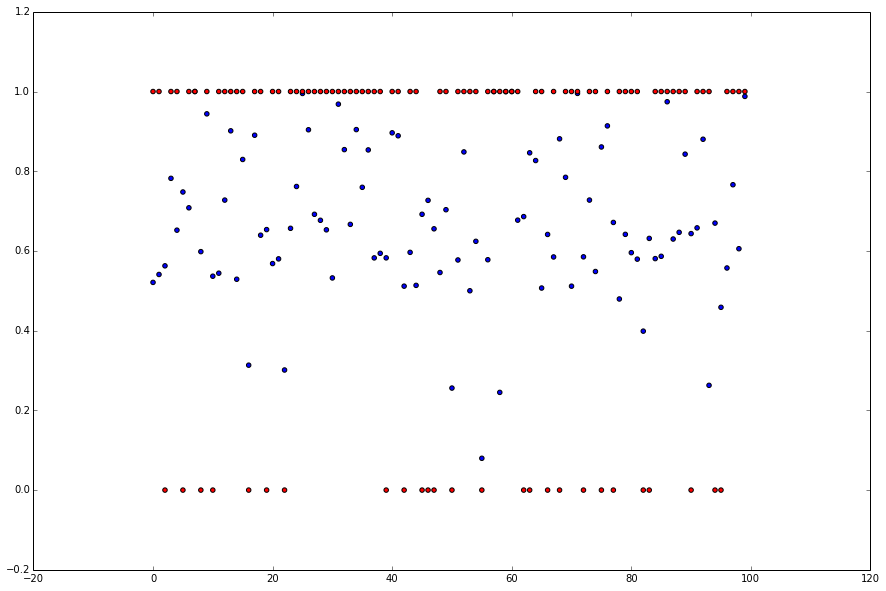

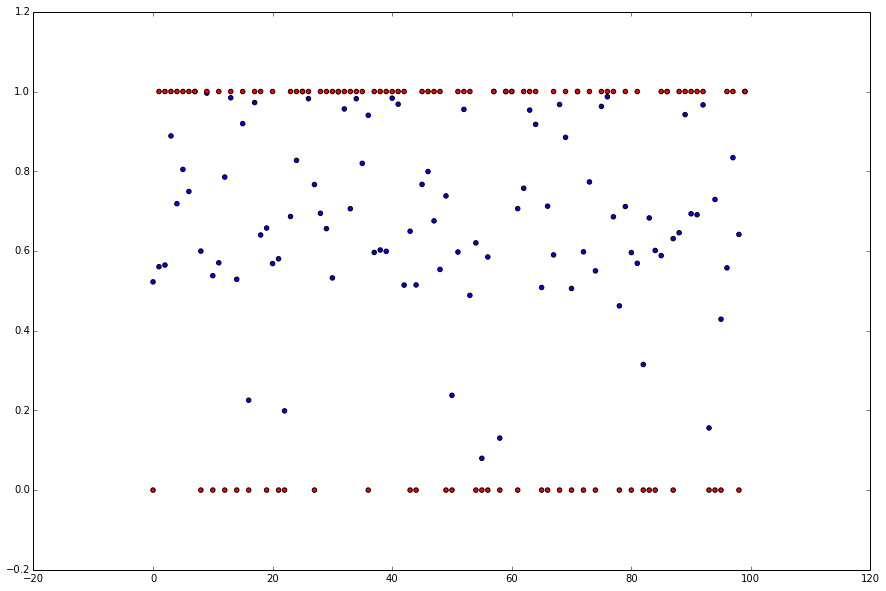

In [66]:
# For each question, show the probability of answering correctly (blue) and the actual answer (red) for 3pl model.
# For ogive, show the probability of answering correctly(yellow) and the actual answer (green).

fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111)
ax.scatter(range(N), probabilities, c="b")
ax.scatter(range(N), u, c="r")
plt.show()

fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111)
ax.scatter(range(N), probabilities_ogive, c="b")
ax.scatter(range(N), u_ogive, c="r")
plt.show()

In [67]:
theta_hats = []
theta_prime_hats = []
confidence_low = []
confidence_high = []
stop_criterion = []
probas_guessed = []
for i in range(N):
    a_so_far = a[:i]
    b_so_far = b[:i]
    c_so_far = c[:i]
    u_so_far = u[:i]
    v_so_far = v[:i]
    
    theta_hat = opt_theta(a_so_far, b_so_far, c_so_far, u_so_far)
    theta_hats.append(theta_hat)
    
    interval = confidence_interval(a_so_far,b_so_far,c_so_far,theta_hat,0.1)
    confidence_low.append(interval[0])
    confidence_high.append(interval[1])
    
    theta_prime_hat = maptheta(a_so_far,b_so_far, c_so_far, u_so_far)
    theta_prime_hats.append(theta_prime_hat)

We compare the performance of the two estimators (ML vs MAP)

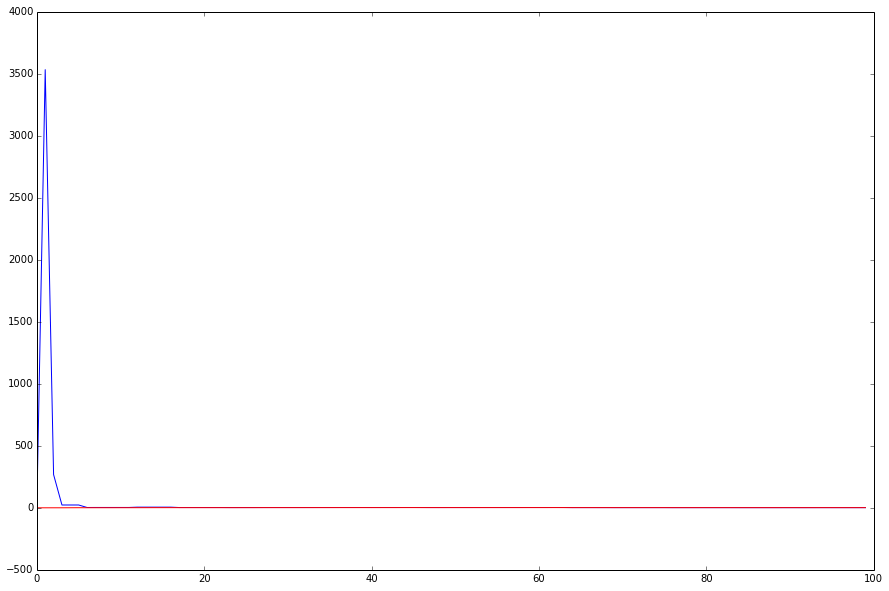

In [68]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111)
ax.plot(theta_hats, c="blue")
ax.plot(theta_prime_hats, c= "red")
#axis([-0.1, 100, -0.2, 200])

In [69]:
final_theta_hat = theta_hats[-1]
"Final estimate (all questions): %f /// Actual: %f" % (final_theta_hat, theta)

'Final estimate (all questions): 1.391393 /// Actual: 1.500000'

We plot the evolution of $\theta$ with its confidence interval in green.

[2, 100, -10, 15]

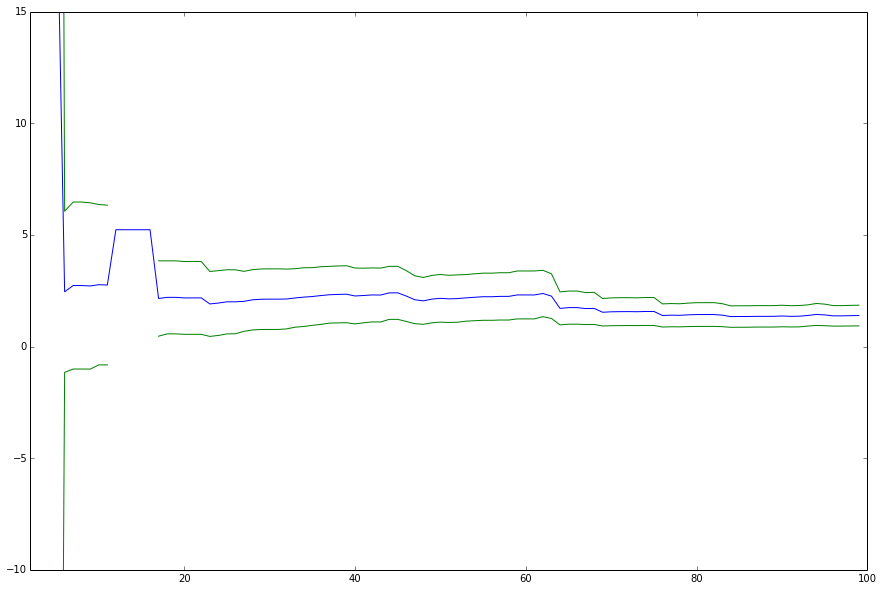

In [71]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111)
ax.plot(theta_hats, c="blue")
ax.plot(confidence_low, c= "green")
ax.plot(confidence_high, c = "green")
axis([2, 100, -10, 15])

Now we will choose which question to ask next according to Fisher Information criterion.

In [73]:
list_theta_guessed = []
list_theta_prime_guessed = []
list_index = np.array(range(N))
stop_criterion = []
j = 0
i_j = [0]
i_l = [0]
proba_guessed = []
R = list_index.copy()
R_prime = list_index.copy()
while len(i_j) < N:
    theta_i = opt_theta(a[i_j], b[i_j], c[i_j], u[i_j])
    theta_prime_i = opt_theta(a[i_l], b[i_l], c[i_l], v[i_l])

    list_theta_guessed.append(theta_i)
    list_theta_prime_guessed.append(theta_prime_i)
    
    k = find_best_question(list_parameters[R],theta_i)
    l = find_best_question(list_parameters[R_prime],theta_prime_i)
    
    i_j.append(R[k])
    i_l.append(R_prime[l])
    
    R = np.delete(R,k)
    R_prime = np.delete(R, l)
    
    p = proba_irt_array(a[i_j],b[i_j],c[i_j], list_theta_guessed[-1])
    
    proba_guessed.append(p)
    
    stop_criterion.append(np.mean(p))
    
    j += 1    

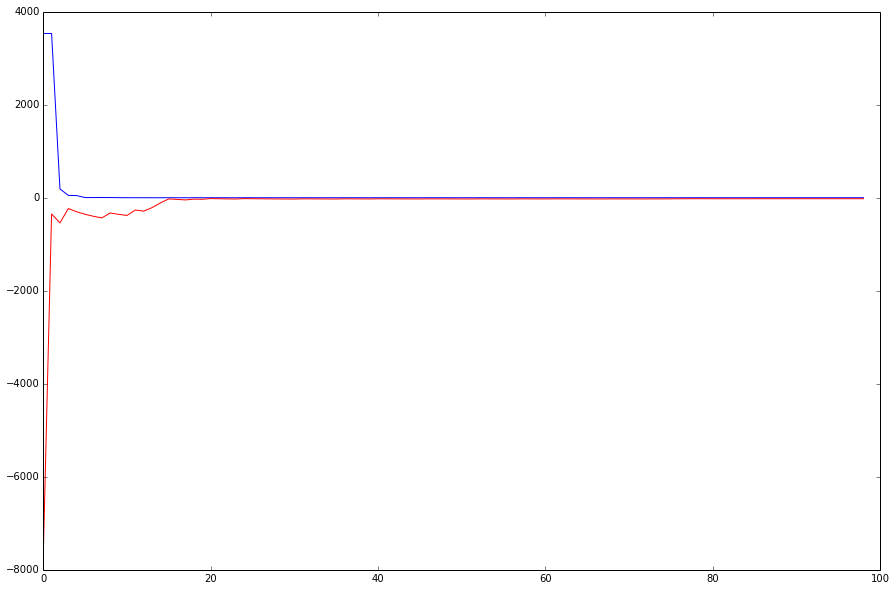

In [74]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111)
ax.plot(list_theta_guessed, c="blue")
ax.plot(list_theta_prime_guessed, c= "red")

We should remember than in order to prevent overfitting we might use half our dataset of users to update parameters that we will use to compute future thetas and the other half to update parameters in order to do the item-selection part.

# Updating our knowledge of a, b, c each time in order to find $\theta$ quicker

TBA

# Using non parametric IRT method in order to compute p($U_{i}$|$\theta$) more effectively

In order to simplify drastically our model and improve computation time we will no longer consider a continuous parameter $\theta$ instead we will consider $\theta$ can only take K values : 0,..,K-1 corresponding to the levels of comprehension of a concept (associated with a capsule). We will generate score panels. For $i \in \{0,..,N\}$ First by using a linear framework : $P(u_i = 1|\theta=\theta_a) = \frac{\theta_a}{K}$. And then by using classic IRT: $P(u_i = 1|\theta=\theta_a) = IRT(\theta_a,a_i,b_i,c_i)$

In [4]:
@jit
def generate_score_panel(number_users, number_questions, k):
    level_users = (np.arange(k)/float(sum(np.arange(k)))).cumsum().searchsorted(numpy.random.sample(number_users))
    p = np.empty(number_users)
    for index,a in enumerate(level_users):
        p[index] = ((k-1.)/2.)*((np.arange(k))/float(sum(np.arange(k))))[a] 
    answers = np.empty([number_users, number_questions])
    for index, proba in enumerate(p):
        answers[index] = np.random.binomial(p=proba,n=1,size=number_questions)
    scores = np.mean(answers, axis=1)
    return answers, scores, level_users

In [5]:
#Run this cell for Linear model test
k = 10
number_users = 200
number_questions = 7
h =  .3
answers, scores, level_user = generate_score_panel(number_users, number_questions, k)


In [6]:
#Run this cell for IRT model test
# Real parameters of the question (no chance answer)
a = 3.
b = 3.

# Number of students
N = 10000

# Student abilities
theta = np.random.uniform(0,1,size=N)

# Student answers
latent_variables = np.array([irt_latent_variable(a, b, t) for t in theta])
u = np.array([[did_answer_correctly(u_star, 0.0) for u_star in latent_variables]])
score = theta
score

array([ 0.54367192,  0.83917854,  0.01444812, ...,  0.32603138,
        0.86646399,  0.6136789 ])

 We will use a non-parametric approach in order to estimate $p(u_i | \theta)$. This methode described in Ramsay (1991) consists in using prior information about how student who did not undertake placement test answered questions. It comprises several steps (Guzman, Conejo, Pérez-de-la-Cruz 2005):

- Prior Student session compilation : We collect information about how student answered question .If we have information on whether he answered the question correctly, we will call the model a dichotomous model and only need one probability distribution per question. If we have information about which proposition a student chose, we can define a probability distribution for each proposition, meaning that if a question has W propositions we will define W-1 probability distributions. First we will only consider dichotomous approach.
- Score Computation : For each student his/her score is computed, we will choose the percentage of good answers as a score.





- Score Transformation : We will then seek the corresponding quantile in the normal distribution. That will give us a score that will be transposed to discrete via a linear transformation.

In [7]:
#Let's assume that there are k knowledge level, we will apply step 3:
@jit
def normalize_score(scores, k):
    a = (k-1.)/5.
    b = (k-1.)/2.
    transformed_score = b+truncnorm(-2.5,2.5).ppf(scores)*a
    return transformed_score

def discretize_score(scores, k):
    transformed_score = normalize_score(scores, k)
    return np.trunc(transformed_score)

- Smoothing : If there were N students who undertook the test, we can approximate P(U_i = 1| \theta) by :

$$\forall k \in [0,K-1], P_i(u_i = 1| \theta = k) = \sum_{a = 1}^{N}{w_{ak}u_{ai}}$$

Where $u_{ai}$ = 1 if student a answered question i correctly. and $w_{ak}$ is calculated as:
$$w_{ak}= \frac{\kappa(\frac{\theta_a-\theta_k}{h})}{\sum_{b=1}^{N}{\kappa(\frac{\theta_b-\theta_k}{h})}}$$
where $\theta_a$ is the knowledge level estimated for student a, $\theta_k$ is the kth knowledge level.

In [8]:
@jit
def generate_weight(scores, k, h, updated_score=None, kernel="gaussian"):
    if updated_score is None:
        transformed_score = normalize_score(scores, k)
    else:
        transformed_score = updated_score
    delta_theta = np.empty([k, len(transformed_score)])
    w = np.empty([k, len(scores)])
    for i in range(k):
        delta_theta[i] = transformed_score - i
    if kernel == "gaussian":
        kernel_transform = exp(-(delta_theta/h)**2)/2.
    elif kernel == "quadra":
        kernel_transform = np.where(abs(delta_theta/h)>1,0,1-(delta_theta/h)**2)
    elif kernel == "unif":
        kernel_transform = np.where(abs(delta_theta/h)>1,0,1)
    sum_kernel_transform = np.sum(kernel_transform, axis=1)
    for index,(a,b) in enumerate(zip(kernel_transform, sum_kernel_transform)):
        w[index] = a/b 
    return w

In [9]:
@jit
def calculate_probas_nonparam(w, answers):
    n_questions = len(answers.T)
    k = len(w)
    probas_calculated = np.empty([n_questions, k])
    for i in range(n_questions):
        for j in range(k):
            probas_calculated[i][j] = np.dot(w[j], answers.T[i])
    return probas_calculated

- Student knowledge level inference : using recently calibrated model one can use the MAP in order to find student's level k.

We can estimate the real ability of users by using :
    $$\forall a \in \{1,..,N\},\forall k \in \{0,..,K-1\}, P(\theta_a=k|u_1,...,u_n)=\prod_{i=1}^{n}{P_i(u_i|\theta_a=k)}.$$
where n is the number of questions. We then use the maximum a posteriori estimator to estimate $\theta$:
$$\forall a \in \{1,..,N\}:k_a=\max_{j \in \{0,..,K-1\}}{P(\theta_a=j|u_1,...,u_n)}, \theta_a = k_a$$

In [10]:
@jit
def find_map(number_users, answers, probas_1,k):
    proba_post = np.empty([number_users,k])
    probas_1t = probas_1.T
    for a in range(number_users):
        n = len(answers[a])
        for level in range(k):
            prod = 1
            mat = np.where(answers[a]==1,probas_1t[level],1-probas_1t[level])
            for i in range(n):
                prod = prod*mat[i]
            proba_post[a][level] = prod
    return np.argmax(proba_post, axis=1)

Then we will use the updated scores found by maximum a posteriori to update our initial estimation, we will do so until probabilities are not fluctuating anymore

In [11]:
@jit
def find_consistent_probas(score, answer, k, h, eps=.1, kernel="gaussian"):
    updated_scores = None
    number_users, number_questions = np.shape(answer)
    #h = (number_users)**(1./5.)
    probas = np.zeros([number_questions,k])
    w = generate_weight(score, k, h, updated_scores,kernel)
    probas_1 = calculate_probas_nonparam(w, answer)
    current_diff = 1000
    while current_diff > eps:
        updated_scores = find_map(number_users,answer, probas_1, k)
        w = generate_weight(score, k, h, updated_scores,kernel)
        probas = calculate_probas_nonparam(w,answer)
        current_diff = np.mean(abs(probas-probas_1))
        probas_1 = probas
    return probas, updated_scores

The following cell is a test of the model. h is the bandwith of the estimation, the smaller h you chose the smaller the bias but the higher the variance. If we assume that the underlying model is approximately gaussian (that our response function are gaussian) one can use Silverman's Rule. The best way to find h is by using cross validation method. $$h = \min_{\hat{h}}{CV(\hat{h})}$$
Where:
$$CV(h) = \int{\hat{P_h}(x)^2dx}-\frac{2}{n(n-1)}\sum_{i=1}^{n}{\sum_{j\neq i}{K(\frac{\theta_i-\theta_j}{h})}}$$

In [12]:
h = .8
consistent_probas, updated_scores = find_consistent_probas(scores, answers, k, h)



In [13]:
from matplotlib.collections import LineCollection
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state
x = np.zeros((number_questions,k))
y = np.zeros((number_questions,k))
y_ = np.zeros((number_questions,k))
for i in range(number_questions):
    x[i] = np.arange(k)
    y[i] = consistent_probas[i]

    # Fit IsotonicRegression in case the estimated probability is not increasing

    ir = IsotonicRegression(increasing=True)

    y_[i] = ir.fit_transform(x[i], y[i])


In [14]:
#This is the mean square error which allows us to measure the accuracy of our estimation
mse = 0
for i in range(number_questions):
    mse += (1./len(y[i]))*np.sum((y_[i]-x[i]/k)**2)
sqrt(mse)

0.31759335812648404

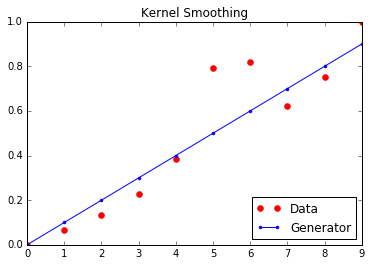

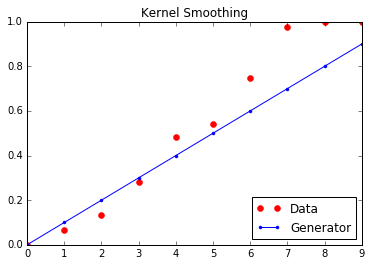

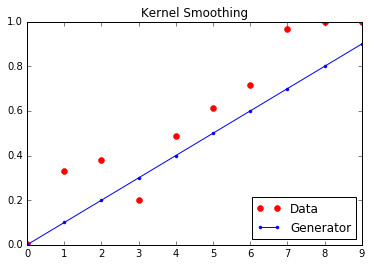

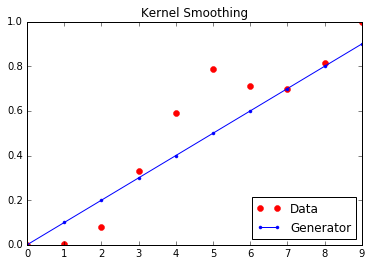

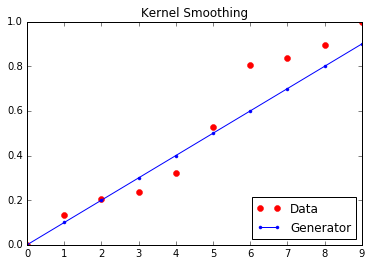

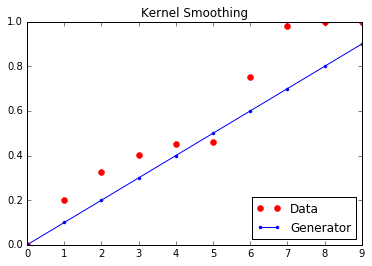

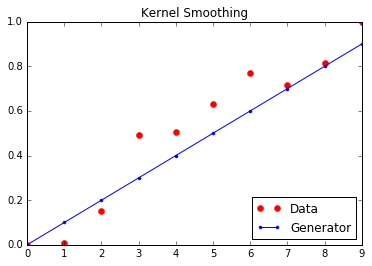

In [15]:
# We hid everything that concerns Isotonic Regression, we will only need it if some curves are non-increasing
for i in range(number_questions):
    #segments = [[[o, y[i][o]], [o, y_[i][o]]] for o in range(k)]
    #lc = LineCollection(segments, zorder=0)
    #lc.set_array(np.ones(len(y[i])))
    #lc.set_linewidths(0.5 * np.ones(k))

    fig = plt.figure()
    plt.plot(x[i], y[i], 'r.', markersize=12)
    #plt.plot(x[i], y_[i], 'g.-', markersize=12)
    plt.plot(x[i], x[i]/k,'b.-')
    #plt.gca().add_collection(lc)
    plt.legend(('Data', 'Generator'), loc='lower right')
    plt.title('Kernel Smoothing')

We will now define a few useful function for our model. First the direct inclusion relation. For $C_i,C_j\in\Omega$ where $\Omega$ is the capsule set, $C_i \in \gamma(C_j)$ if there is an arc in the graph between $C_i$ and $C_j$. It corresponds to children of $C_j$.

In [16]:
def gamma_corresp(C):
    return set(map_graph.neighbors(C, mode="ALL"))

In [17]:
def create_map_graph(edges_list,N=None):
    map_graph = Graph(edges_list, directed=True)
    map_graph.vs["label"] = map_graph.vs["name"] = [str(i+1) for i, v in enumerate(map_graph.vs)]
    if N is not None:
        map_graph.vs["item pool"] = [["q_"+str(i+1)+"_"+str(j+1) for j in range(N[i])] for i, v in enumerate(map_graph.vs)]
    return map_graph

def plot_map_graph(map_graph):
    layout = map_graph.layout_sugiyama()
    return igraph_plot(map_graph, bbox=(400, 400), layout=layout)

In [18]:
#Example
edges_list = [
    (0, 1),
    (0, 2),
    (2, 3),
    (1, 3)
]
N = [7, 6, 5, 7] 

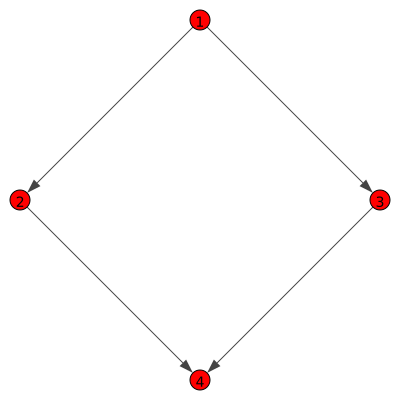

In [19]:
map_graph = create_map_graph(edges_list,N)
plot_map_graph(map_graph)

Then the inclusion relation. For $C_i,C_j\in\Omega$, $C_i \in \gamma^+(C_j)$ if there is a directed path in the graph between that comes from $C_j$ and goes to $C_i$.

In [20]:
def gamma_plus(C):
    nodes = set([C])
    linked_nodes = set(map_graph.neighbors(C,mode="OUT"))
    while len(nodes) > 0:
        for node in nodes:
            nodes = set(map_graph.neighbors(node,mode="OUT"))
            linked_nodes=linked_nodes|set(map_graph.neighbors(node,mode="OUT"))
    return linked_nodes

Finally the indirect inclusion relation. For $C_i,C_j\in\Omega$, $C_i \in \gamma^{++}(C_j)$ if there is an inclusion relationship between the two but no direct inclusion relationship.

In [21]:
def gamma_plus_plus(C):
    return gamma_plus(C) - gamma_corresp(C) 


We also must define the association of an item to a concept. If $Q_i \in \Pi$ the item pool
and $C_j \in \Omega$, item $Q_i$ is associated to concept $C_j$ (or item $Q_i$ directly evaluates concept
$C_j$) if the author of the capsule has stated that the probability of solving correctly $Q_i$ depends on
the knowledge of $C_j$. That is, the answer selected by a student for that item allows
us to make inferences about his/her knowledge level in that concept. To represent
this relation, we define the function $E_D :  \Pi × \Omega → \{0, 1\}, E_D(Q_i, C_j) = 1$ if $Q_i$ is
associated to $C_j$, otherwise $E_D(Q_i, C_j) = 0$. 

In [22]:
def association_item_concept(item, concept):
    return ("q_"+concept+"_"+item.split("_")[2] in map_graph.vs["item pool"][int(concept)-1])&(item.split("_")[1] == concept)

However, despite the fact that each item directly evaluates one and only one concept,
it can indirectly evaluate several concepts (Guzmán and Conejo 2002), by taking
into account the relations among concepts of the tree. Given an item $Q_i$ and a concept
$C_j$, the indirect evaluation function of a concept from an item, $E_I : \Pi × \Omega \rightarrow \{0, 1\}$,
is defined as follows: $E_I(Q_i, C_j) = 1$ if $E_D(Q_i, C_j) = 0$, and exists $C_l \in \Omega$ such that
$E_D(Q_i, C_l) = 1$ and $C_l \in \gamma^{+}(C_j)$; otherwise $E_I(Q_i, C_j) = 0$. That is, $Q_i$ indirectly
evaluates $C_j$ when there is another concept $C_l$ evaluated directly by $Q_i$ and between
them there is an indirect inclusion relation. Notice that the item $Q_i$ is not associated
to the concept, i.e., does not belong directly to its item pool.

In [23]:
def indirect_association_item_concept(item, concept):
    if association_item_concept(item, concept):
        return False
    return int(concept)-1 in gamma_plus(item.split("_")[1])

    

An item $Q_i$ evaluates a concept $C_j$ when $Q_i$ evaluates $C_j$ either directly or indirectly.
The corresponding function will be $E :\Pi×\Omega→ \{0, 1\}, E(Q_i, C_j) = E_D(Q_i, C_j) +
E_I(Q_i, C_j)$.

In [24]:
def total_association_item_concept(item, concept):
    return indirect_association_item_concept(item, concept) + association_item_concept(item, concept)

Now we will implement an a priori distribution for $P(\theta)$, since we have knowledge on the mean value of theta, we can discretize a normal distribution with mean equal to the mean of theta.

In [25]:
def p_theta(k, knowledge_distribution = None):
    p_theta = np.arange(k)
    if knowledge_distribution is not None:
        mean = np.mean(knowledge_distribution)
        std = np.std(knowledge_distribution)
        custom_norm = norm(loc=mean,scale=std) # We might need to adjust this parameter
        p_theta=custom_norm.cdf(p_theta)
        y = np.zeros(k)
        y[1:] = p_theta[:-1]
        p_theta = p_theta - y
    else:
        p_theta = 1/(k*np.ones(k))
    return p_theta
        

We will initialize our model, 200 users answered every question, thus allowing us to measure their knowledge level:

In [26]:
k = 10
number_users = 1000
number_questions = N
h =  .8
answers = []
scores = []
level_users = []
for i in range(len(N)):
    answer, score, level_user = generate_score_panel(number_users, number_questions[i], k)
    answers.append(answer)
    scores.append(score)
    level_users.append(level_user)
    

In [27]:
proba_updaters = []
scores_updated = []
for i in range(len(N)):
    consistent_probas, updated_scores = find_consistent_probas(scores[i], answers[i], k, h)
    proba_updaters.append(consistent_probas)
    scores_updated.append(updated_scores)

In [28]:
p_theta_all = []
for i in range(len(N)):
    p_theta_all.append(p_theta(k,scores_updated[i]))

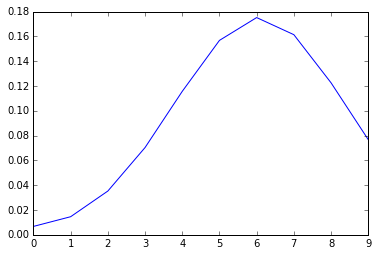

In [29]:
#An example of how our discretized distributions look
plt.plot(p_theta_all[0])

We will use a bayesian framework to update our knowledge of $\theta_j,j \in \{1,..,M\}$, given $\vec{u_t}=\{u_1,..,u_t\}$ namely :
$$ \forall j \in \{1,..,M\},P(\theta_j|\vec{u_t})= \begin{cases} 
      \|P(\theta_j|\vec{u_{t-1}})\cdot P(u_t|\theta_j)\| & E(Q_t,C_j)=1 \\
      P(\theta_j|\vec{u_{t-1}}) & \mbox{otherwise} 
   \end{cases}
$$

In [30]:
def update_proba(map_graph, p_theta, p_u, q, u, normalized=True):
    question = q.split('_')
    p_theta_upd = np.copy(p_theta)
    index_question, index_caps_orig = int(question[2]) - 1, int(question[1]) -1
    for capsule in map_graph.vs["name"]:
        index_capsule = int(capsule) -1
        if total_association_item_concept(q, capsule):
            p_u_knowing_theta = p_u[index_caps_orig][index_question]
            if u == 0:
                p_u_knowing_theta = 1 - p_u_knowing_theta
            p_theta_upd[index_capsule] = p_theta_upd[index_capsule]*p_u_knowing_theta
            if normalized:
                p_theta_upd[index_capsule] *= 1./(sum(p_theta_upd[index_capsule]))
        else:
            if not(normalized):
                p_theta_upd[index_capsule] = 1./(len(p_theta_upd[index_capsule])*np.ones(len(p_theta_upd[index_capsule])))
    return p_theta_upd
            

In [31]:
def find_map_for_adaptive_testing(p_theta):
    theta = np.zeros(len(p_theta))
    for i in range(len(p_theta)):
        theta[i] = np.argmax(p_theta[i])
    return theta

We will implement the Maximum expected accuracy-based Bayesian method. We have a set of N capsules : $\{C_1,..,C_N\}$. We will chose the question that fulfills:
$$\min_{Q_j\in \Theta}{\sum_{s=1}^{N}{\sigma^2[\rho_0(\theta_s|\vec{u_{i-1}},u_j=0)]\cdot\nu_{0js}+\sigma^2[\rho_1(\theta_s|\vec{u_{i-1}},u_j=1)]\cdot\nu_{1js}}}$$
Where : $$\rho_w(\theta_s|\vec{u_{i-1}},u_j=w)= \begin{cases} 
      \|P(\theta_j|\vec{u_{i-1}})\cdot P(u_j=w|\theta_j)\| & E(Q_t,C_j)=1 \\
      P(\theta_j|\vec{u_{i-1}}) & \mbox{otherwise} 
   \end{cases}$$
and :
$$ \nu_{wjs}=\begin{cases} 
      < P(\theta_j|\vec{u_{i-1}}), P(u_j=w|\theta_j)> & E(Q_t,C_j)=1 \\
      1 & \mbox{otherwise} \end{cases}$$
where <,> is the scalar product.

In [32]:
def find_next_question(map_graph, p_theta, p_u,N,list_to_mask):
    list_info_questions = [np.ma.masked_array([0. for j in range(N[i])],mask=list_to_mask[i],fill_value=1e-20) for i in range(len(N))] 
    for i in range(len(N)):
        for j in range(N[i]):
            if list_info_questions[i][j] is not(ma.masked):
                sum_prob = 0
                for s in range(len(p_theta)):
                    q = "q_"+str(i+1)+"_"+str(j+1)
                    rho_0 = update_proba(map_graph, p_theta, p_u,q,0)[s]
                    rho_1 = update_proba(map_graph, p_theta, p_u,q,1)[s]
                    sigma_0 = np.std(rho_0)**2
                    sigma_1 = np.std(rho_1)**2
                    nu_0 = np.sum(update_proba(map_graph, p_theta, p_u,q,0,False)[s])
                    nu_1 = np.sum(update_proba(map_graph, p_theta, p_u,q,1,False)[s])
                    sum_prob += sigma_0*nu_0+sigma_1*nu_1
                list_info_questions[i][j] = sum_prob
    capsules_max = [
        np.max(capsule) if np.max(capsule) is not(ma.masked) else None for capsule in list_info_questions 
    ]
    i_max = argmax(capsules_max)
    j_max = argmax(list_info_questions[i_max])

    return i_max,j_max


In [33]:
def stopping_criterion_map(p_theta, delta=0.75, eps=.15,criterion="MAP"):
    if criterion == "MAP":
        for i in range(len(p_theta)):
            if (p_theta[i][find_map_for_adaptive_testing(p_theta)[i]] <= delta):
                return False
    elif criterion == "STD":
        for i in range(len(p_theta)):
            if (np.std(p_theta[i]) >= eps):
                return False
    elif criterion == "custom":
        for i in range(len(p_theta)):
            if (sum(p_theta[i][:3]) <= delta)&(sum(p_theta[i][:-3]) <= delta):
                return False
    return True


How does the prior estimation react when for example someone answered questions of capsule 2 all wrong ? Let's remember what is the graph's form :

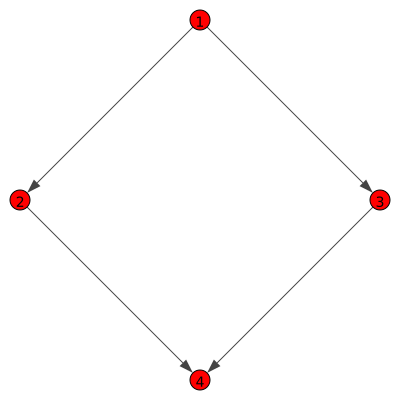

In [34]:
plot_map_graph(map_graph)

So this response pattern should decrease the likelihood of mastering 2 and 4, but left the others unchanged.

In [ ]:
p_theta_updated = np.copy(p_theta_all)
for i in range(N[1]):
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(p_theta_updated[j])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc='lower right')
    p_theta_updated = update_proba(map_graph, p_theta_updated, proba_updaters, "q_2_"+str(i+1), 0)


Bingo !! Now our user will answer correctly every question of capsule 1, impacting every capsules :

In [ ]:
p_theta_updated = np.copy(p_theta_all)
for i in range(N[0]):
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(p_theta_updated[j])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc='lower right')
    p_theta_updated = update_proba(map_graph, p_theta_updated, proba_updaters, "q_1_"+str(i+1), 1)


Now the there is an user answering to capsule 4 randomly :


In [ ]:
p_theta_updated = np.copy(p_theta_all)
for i in range(N[0]):
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(p_theta_updated[j])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc='lower right')
    p_theta_updated = update_proba(map_graph, p_theta_updated, proba_updaters, "q_4_"+str(i+1), np.random.binomial(p=0.5,n=1))


In [35]:
# Let's do a quick simulation 

user_answers = np.array([[1,0,1,1,0,1,1],[0,1,0,0,1,1],[1,1,0,0,0],[0,0,0,0,0,1,1]])
list_to_mask = np.array([[0,0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0,0,0]])
for e in user_answers:
    print np.mean(e)


0.714285714286
0.5
0.4
0.285714285714


/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(2, 1)
(4, 4)
(1, 5)
(9, 1)
(4, 0)
(4, 5)
(8, 0)
(4, 1)
(4, 6)
(4, 2)
(6, 5)
(2, 4)
(9, 0)
(6, 2)
(6, 7)
(6, 4)
(2, 2)
(2, 0)
(6, 1)
(6, 3)
(6, 0)
(9, 4)
(3, 2)
(9, 2)
(8, 1)
(1, 1)
(1, 2)
(5, 4)
(8, 4)
(6, 6)
(2, 3)
(8, 5)
(8, 3)
(3, 0)
(3, 3)
(8, 2)
(5, 1)
(3, 4)
(5, 7)
(1, 3)
(5, 6)
(1, 0)
(5, 2)
(5, 0)
(3, 5)
(3, 1)
(3, 6)
(1, 4)
(5, 3)
(5, 8)
(5, 5)
(0, 6)
(0, 4)
(0, 5)
(0, 0)
(0, 3)
(0, 2)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


KeyboardInterrupt: 

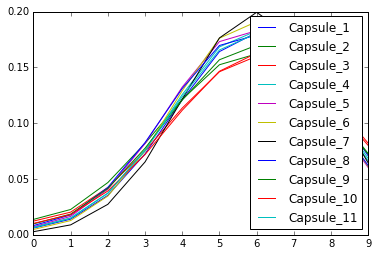

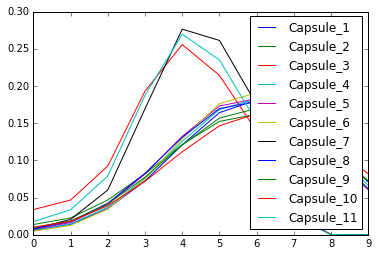

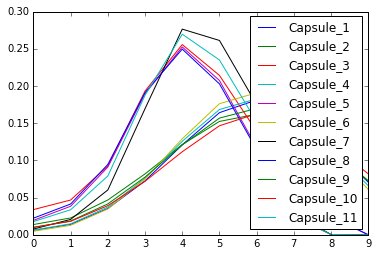

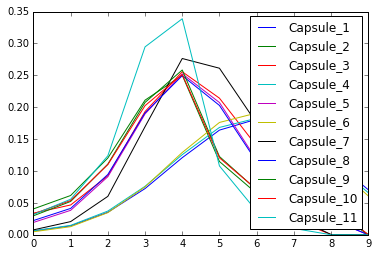

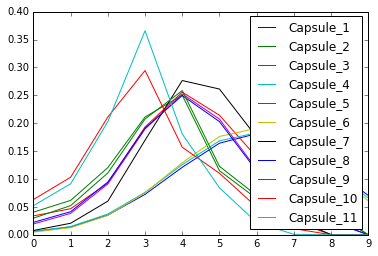

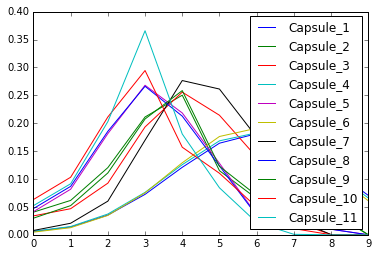

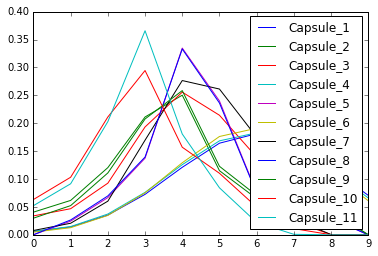

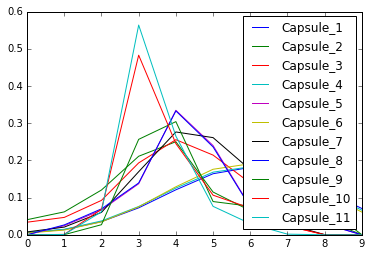

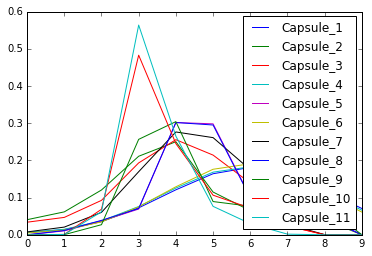

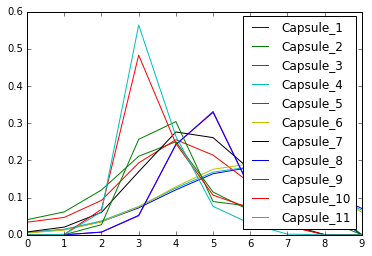

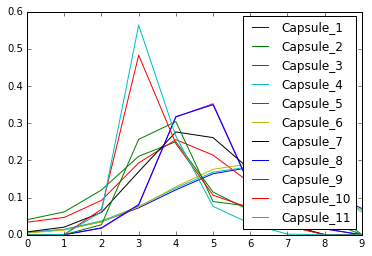

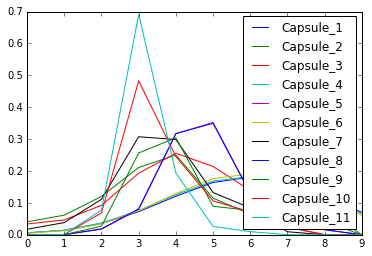

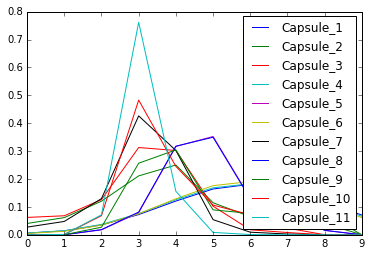

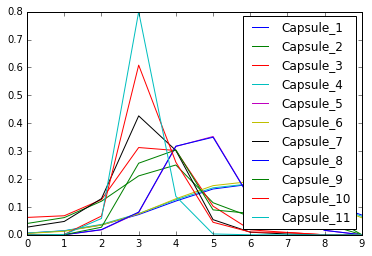

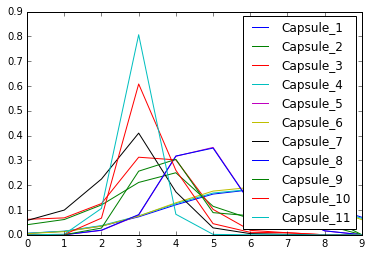

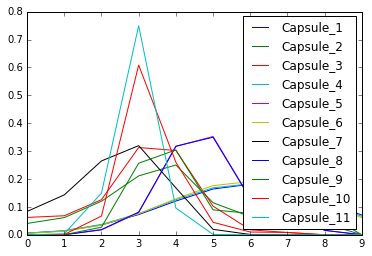

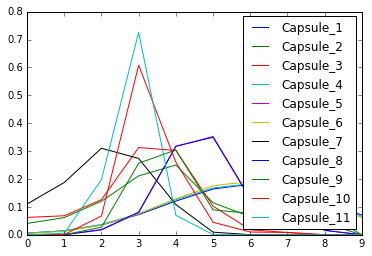

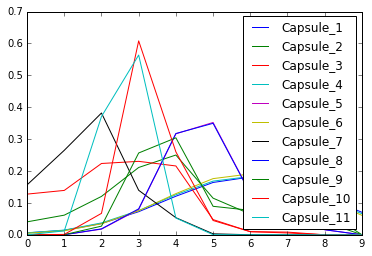

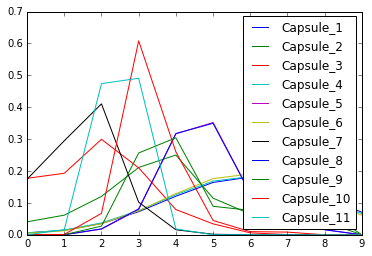

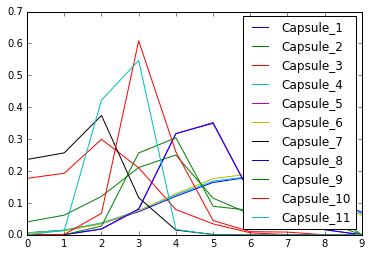

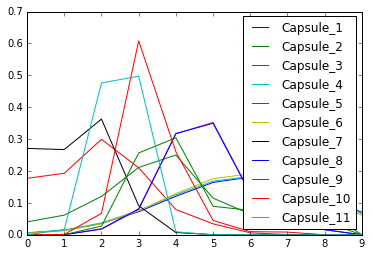

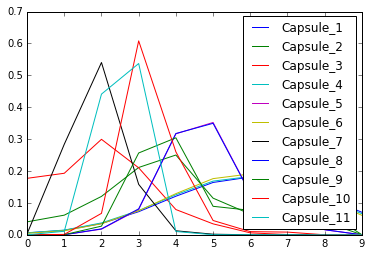

KeyboardInterrupt: 

In [51]:
q_i_j = find_next_question(map_graph,p_theta_all,proba_updaters,N,list_to_mask)
p_theta_up = np.copy(p_theta_all)
while not(stopping_criterion_map(p_theta_up,delta=.5,criterion="MAP"))&(np.a):
    print q_i_j
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(p_theta_up[j])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc='lower right')
    i = q_i_j[0]
    j = q_i_j[1]
    p_theta_up = update_proba(
            map_graph,
            p_theta_up,
            proba_updaters,
            "q_"+str(i+1)+"_"+str(j+1),
            user_answers[i][j]
        )
    list_to_mask[i][j] = 1
    q_i_j = find_next_question(map_graph,p_theta_up,proba_updaters,N,list_to_mask)


In [37]:
list_to_mask

array([[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]], dtype=object)

Let's try with a bigger map:


In [38]:
edges_list = [
    (0, 2),
    (0, 3),
    (0, 4),
    (0, 5),
    (5, 8),
    (1, 8),
    (2, 6),
    (3, 6),
    (3, 7),
    (4, 7),
    (6, 10),
    (8, 9),
    (9, 10)
]
N = [7, 6, 5, 7, 8, 9, 8, 7, 6, 5, 9] # Number of questions in each capsule

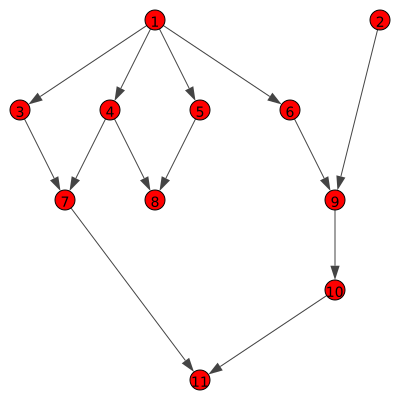

In [39]:
map_graph = create_map_graph(edges_list,N)
plot_map_graph(map_graph)

In [40]:
k = 10
number_users = 200
number_questions = N
h =  .8
answers = []
scores = []
level_users = []
for i in range(len(N)):
    answer, score, level_user = generate_score_panel(number_users, number_questions[i], k)
    answers.append(answer)
    scores.append(score)
    level_users.append(level_user)

In [41]:
proba_updaters = []
scores_updated = []
for i in range(len(N)):
    consistent_probas, updated_scores = find_consistent_probas(scores[i], answers[i], k, h)
    proba_updaters.append(consistent_probas)
    scores_updated.append(updated_scores)

In [42]:
p_theta_all = []
for i in range(len(N)):
    p_theta_all.append(p_theta(k,scores_updated[i]))

In [49]:
proba_ans = [0.8,0.5,0.3,0.7,0.7,0.2,0.1,0.4,0.9,0.1,0.6]
user_answers = np.array([np.random.binomial(p=proba_ans[i],n=1,size=N[i]) for i in range(len(N))])
list_to_mask = user_answers/100
for e in user_answers:
    print np.mean(e)

0.714285714286
0.166666666667
0.0
0.857142857143
0.625
0.333333333333
0.125
0.571428571429
1.0
0.0
0.666666666667


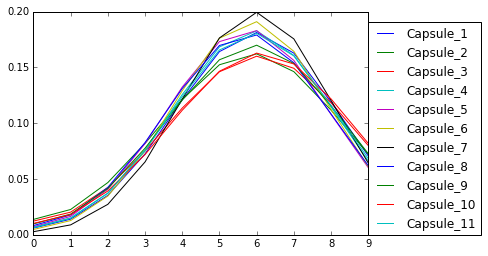

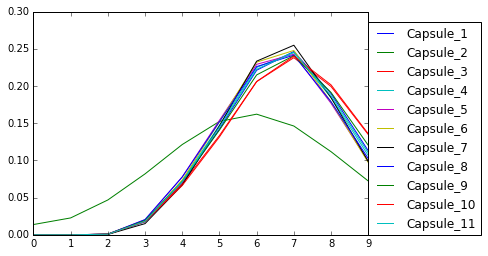

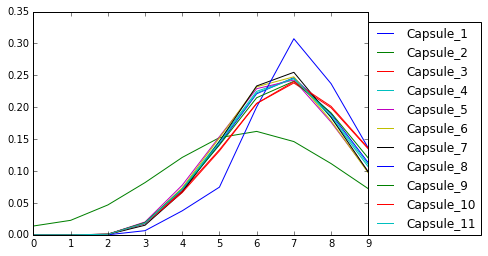

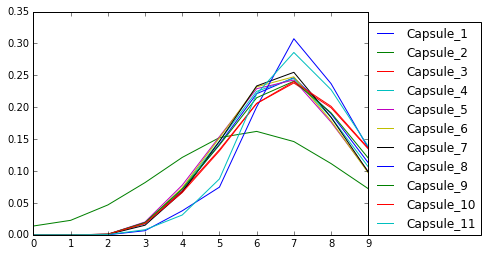

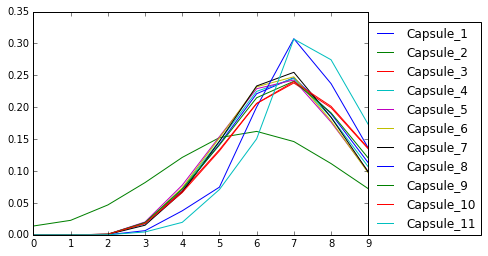

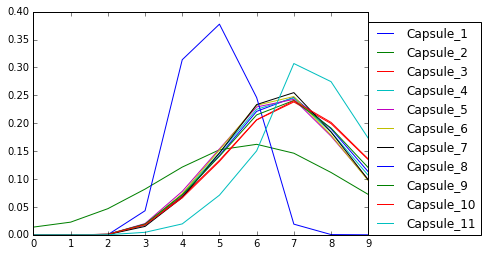

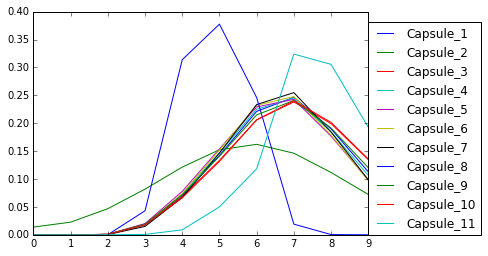

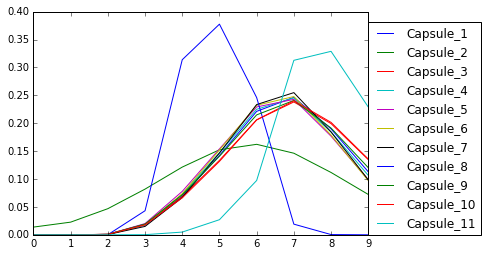

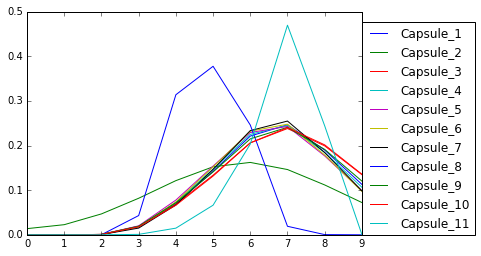

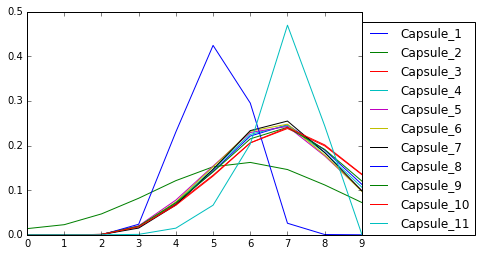

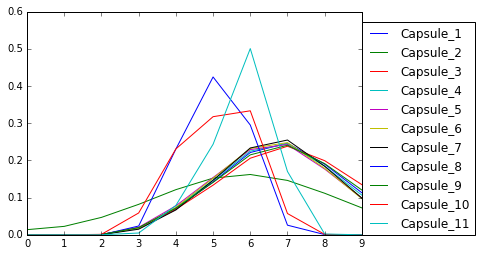

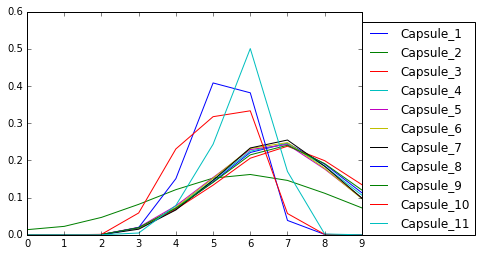

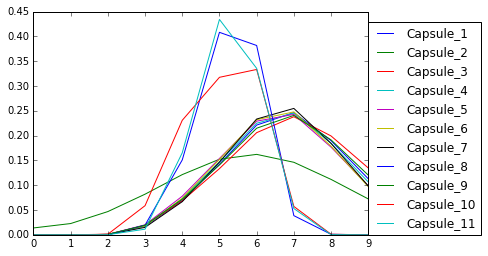

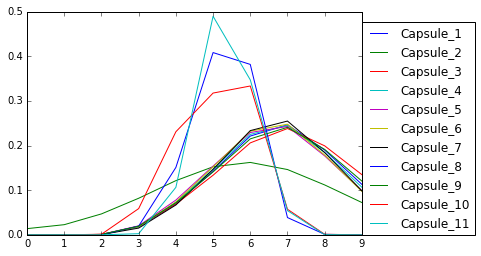

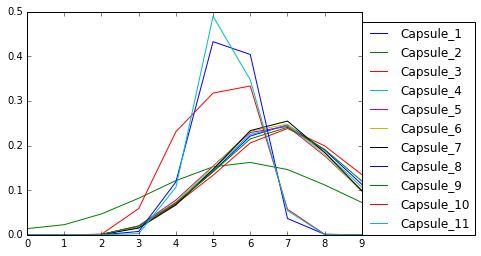

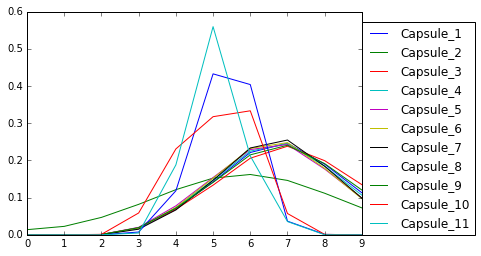

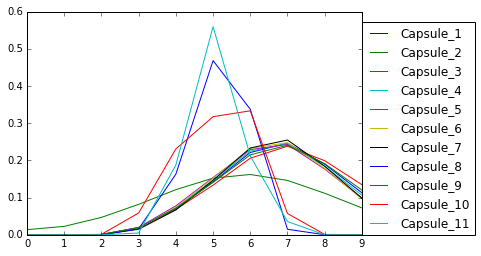

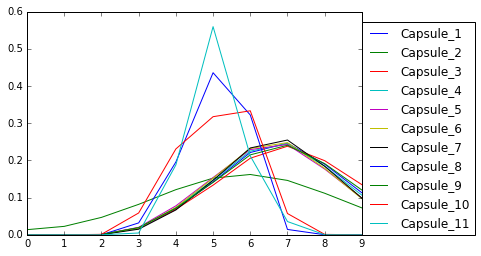

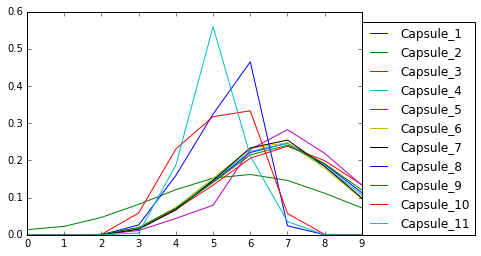

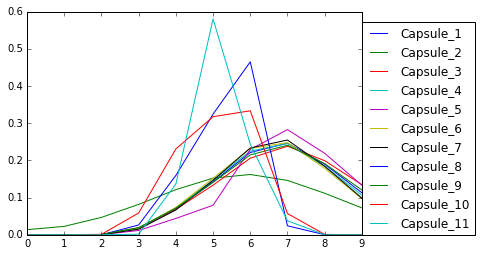

In [50]:
q_i_j = find_next_question(map_graph,p_theta_all,proba_updaters,N,list_to_mask)
p_theta_up = np.copy(p_theta_all)
count = 0
list_asked_questions = [q_i_j]
while count<20:
    i = q_i_j[0]
    j = q_i_j[1]
    fig = plt.figure()
    for f in range(len(N)):
        plt.plot(p_theta_up[f])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc=[1,0])
    p_theta_up = update_proba(
            map_graph,
            p_theta_up,
            proba_updaters,
            "q_"+str(i+1)+"_"+str(j+1),
            user_answers[i][j]
        )
    list_to_mask[i][j] = 1
    q_i_j = find_next_question(map_graph,p_theta_up,proba_updaters,N,list_to_mask)
    count +=1
    list_asked_questions.append(q_i_j)

In [ ]:
list_to_mask